In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import string
import ast
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import string

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
nltk.download('omw-1.4')
stopwords = set(stopwords.words("english"))

import pyLDAvis.sklearn
import math
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is alr

In [2]:
tweetDf = pd.read_csv('data123.csv')

In [3]:
tweetDf['Date'] = pd.to_datetime(tweetDf['Date'], format= '%Y-%m-%d %H:%M:%S')

In [4]:
tweetDf.sort_values(by='Date', inplace=True)

In [5]:
# Delete duplicate rows based on specific columns 
tweetDf = tweetDf.drop_duplicates(subset=["Tweet"], keep="last")
tweetDf['Tweet'] = tweetDf['Tweet'].str.lower()
tweetDf['Hashtags'] = tweetDf['Hashtags'].str.lower()
tweetDf['Hashtags'] = tweetDf['Hashtags'].replace(np.nan,'no hashtags')
tweetDf['Location'] = tweetDf['Location'].replace(np.nan,'US,US')
tweetDf['Mentioned User'] = tweetDf['Mentioned User'].replace(np.nan,'no mentions')
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'bammer'], inplace=True)
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'bomb'], inplace=True)
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'blunt'], inplace=True)
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'dope'], inplace=True)

In [6]:
start_date = '2022-10-06 19:00:00'
end_date = '2022-10-06 19:53:00'
# Select DataFrame rows between two dates
mask = (tweetDf['Date'] > start_date) 
afterDf = tweetDf.loc[mask]
afterDf.shape

start_date = '2022-10-06 18:59:59'
# Select DataFrame rows between two dates
mask = (tweetDf['Date'] < start_date) 
beforeDf = tweetDf.loc[mask]
beforeDf.shape


(2726, 11)

In [7]:
beforeDf = beforeDf.reset_index(drop=True)
afterDf = afterDf.reset_index(drop=True)


In [8]:
def hashtags(text):
    
    hashtag = []  
    for i in text:
        if i != 'no hashtags':

            for j in ast.literal_eval(i):
                hashtag.append(j)
    return hashtag

In [9]:
beforeHashtag = hashtags(beforeDf['Hashtags'])
afterHashtag = hashtags(afterDf['Hashtags'])

In [10]:
beforeHashtag = {x:beforeHashtag.count(x) for x in beforeHashtag}
afterHashtag = {x:afterHashtag.count(x) for x in afterHashtag}

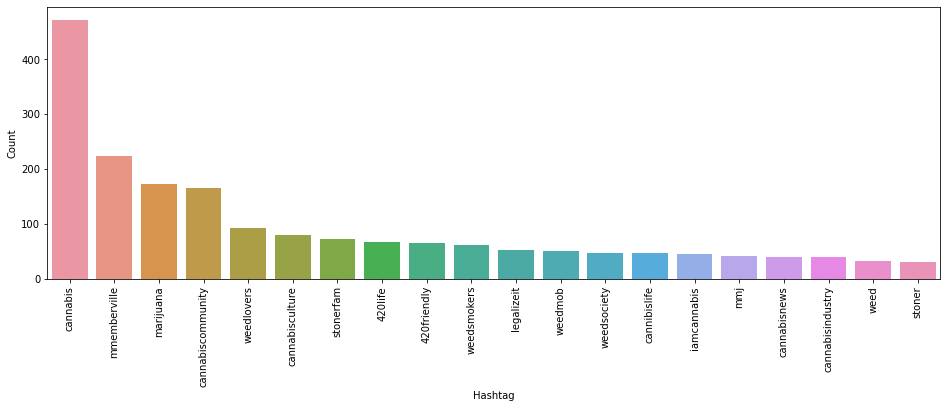

In [11]:
a = nltk.FreqDist(beforeHashtag)
n_largest_hashtags = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags    
n_largest_hashtags = n_largest_hashtags.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=n_largest_hashtags, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.show()

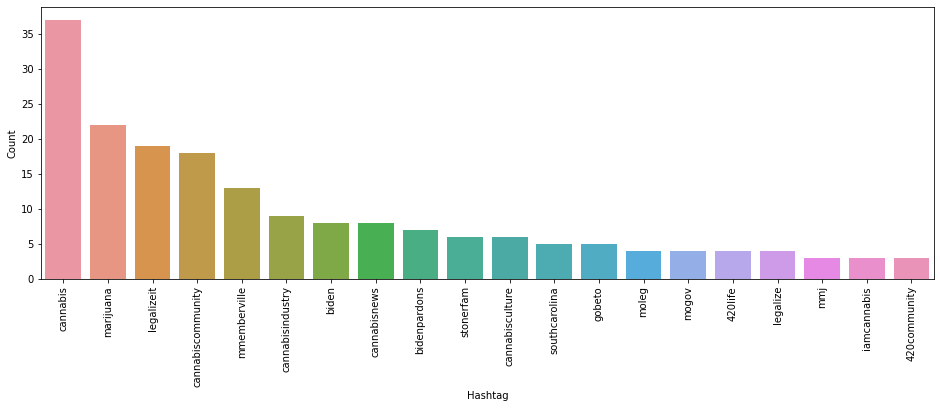

In [12]:
a = nltk.FreqDist(afterHashtag)
n_largest_hashtags = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags    
n_largest_hashtags = n_largest_hashtags.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=n_largest_hashtags, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.show()

In [13]:
#function to extract mentions from text
def mentions(x):
    # @x : text parameter to the function
    mentions = []
    for i in x:
        # re for finding mentions
        ht = re.findall(r'@[\w]*', i)
        # storing hashtags in list
        mentions.append(ht)
    # returns mentions from the function
    return mentions

In [14]:

#storing the mentions in list
beforeMentions = mentions(beforeDf['Tweet'])

    # getting sum of the mentions
beforeMentions = sum(beforeMentions,[])


In [15]:
#storing the mentions in list
afterMentions = mentions(afterDf['Tweet'])

    # getting sum of the mentions
afterMentions = sum(afterMentions,[])

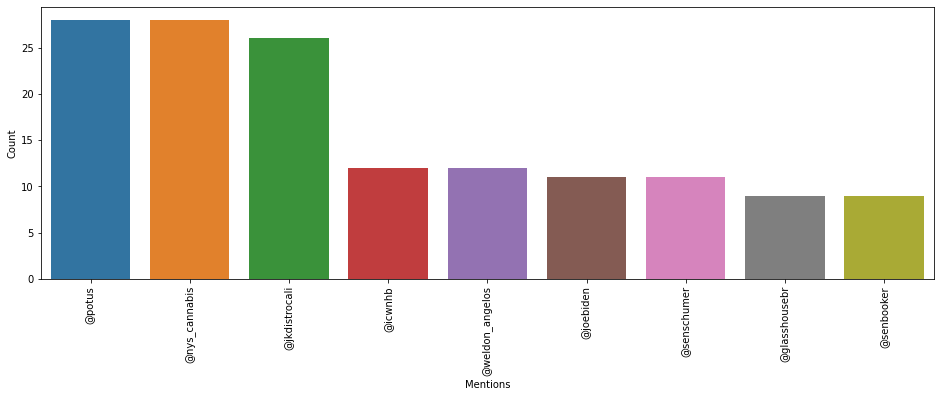

In [16]:
a = nltk.FreqDist(beforeMentions)
n_largest_mentions = pd.DataFrame({'Mentions': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags    
n_largest_mentions = n_largest_mentions.nlargest(columns="Count", n = 10)
n_largest_mentions.drop(n_largest_mentions.index[n_largest_mentions['Mentions'] == '@'], inplace=True)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=n_largest_mentions, x= "Mentions", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.show()

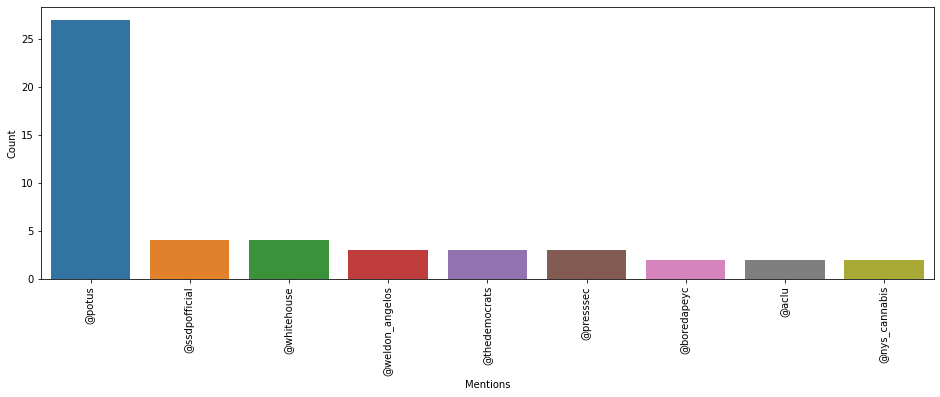

In [17]:
a = nltk.FreqDist(afterMentions)
n_largest_mentions = pd.DataFrame({'Mentions': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags    
n_largest_mentions = n_largest_mentions.nlargest(columns="Count", n = 10)
n_largest_mentions.drop(n_largest_mentions.index[n_largest_mentions['Mentions'] == '@'], inplace=True)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=n_largest_mentions, x= "Mentions", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.show()

In [18]:
clean_tweets = []   
for index, row in beforeDf.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Tweet.split() if 'http' not in word]
    clean_tweets.append(' '.join(words_without_links))
beforeDf['Tweet'] = clean_tweets

In [19]:
clean_tweets = []   
for index, row in afterDf.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Tweet.split() if 'http' not in word]
    clean_tweets.append(' '.join(words_without_links))
afterDf['Tweet'] = clean_tweets

In [20]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

beforeDf['Tweet'] = np.vectorize(remove_pattern)(beforeDf['Tweet'], r"RT\s*:")
afterDf['Tweet'] = np.vectorize(remove_pattern)(afterDf['Tweet'], r"RT\s*:")

In [21]:
#creating the function to clean th text of tweets

def cleantextdata(text):

    # funtion to clean emojies
    def deEmojify(text):
        regrex_pattern = re.compile(pattern = "["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\U00002500-\U00002BEF"  # Chinese char
                        u"\U00010000-\U0010ffff"
                               "]+", flags = re.UNICODE)
        return regrex_pattern.sub(r'',text)
    
    #removes all the mentions in the tweets
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    
    #removes  and replaces with '', if there are any characters with '@' character
    text = re.sub(r'@+','',text)
    #removes  and replaces with '', if there are any characters with '_' character
    text = re.sub(r'_*','',text)
    
    #removes  and replaces with '', if there are any characters with '.' character
    text = re.sub(r'/.+','',text)
    
    #removes all the hash tag in the tweet
    text = re.sub(r'#[A-Za-z0-9]+','',text)
    
    #removes next line character and replaces with ''
    text = re.sub(r'\n+',' ',text)
    
    #removes all the emojies from text replaces it with ''
    text = deEmojify(text)
    
    #removes all the pucntuations in the text replaces it with ''
    text = text.translate(str.maketrans('','',string.punctuation))
    
    #removes and replaces the extra space in the text with ''
    text = re.sub(r'^\s+|\s+$|\s+(?=\s)/g','',text)
    
    #removes and replaces the extra space in the text with ''
    text = re.sub(r'\s+',' ',text)
    
    #removes the space between words like ca nt, have nt and joins the words
    if " nt" in text:

        text = re.sub(r'\s+nt',"nt",text)
    #removes all the pucntuations in the text replaces it with ''
    text = text.translate(str.maketrans('','',string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [22]:
beforeDf['TweetCleaned'] = beforeDf['Tweet'].apply(cleantextdata)
afterDf['TweetCleaned'] = afterDf['Tweet'].apply(cleantextdata)

In [23]:
stopwords_set = set(stopwords)
cleaned_tweets = []


for index, row in beforeDf.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.TweetCleaned.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
beforeDf['TweetCleaned'] = cleaned_tweets


In [27]:
stopwords_set = set(stopwords)
cleaned_tweets_after = []


for index, row in afterDf.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.TweetCleaned.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets_after.append(' '.join(words_without_stopwords))
    
afterDf['TweetCleaned'] = cleaned_tweets_after

In [28]:
tokenized_tweet_before = beforeDf['TweetCleaned'].apply(lambda x: x.split())

In [29]:
    
word_lemmatizer = WordNetLemmatizer()


tokenized_tweet_before = tokenized_tweet_before.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet_before.head()

    
for i, tokens in enumerate(tokenized_tweet_before):
    tokenized_tweet_before[i] = ' '.join(tokens)
    


beforeDf['TweetCleaned'] = tokenized_tweet_before

In [30]:
tokenized_tweet_after = afterDf['TweetCleaned'].apply(lambda x: x.split())

In [31]:
word_lemmatizer = WordNetLemmatizer()  
tokenized_tweet_after = tokenized_tweet_after.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
  
for i, token in enumerate(tokenized_tweet_after):
    tokenized_tweet_after[i] = ' '.join(token)


afterDf['TweetCleaned'] = tokenized_tweet_after

In [36]:

#
# LDA parameters
#

# number of topics to discover (default = 10)
topicNum = 5
# maximum number of words to display per topic (default = 10)
# Answer to Exercise 1 (change from 10 to 15)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
# please feel free to change to see effect
featureNum = 1000



In [37]:
# Count Vectorizer
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(beforeDf['TweetCleaned'])
# extract the names of the features 
tfFeatureNames = tfVectorizer.get_feature_names()

#
# LDA MODEL
#
# Run LDA 
ldaModelbefore = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [41]:
# Count Vectorizer
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(afterDf['TweetCleaned'])
# extract the names of the features 
tfFeatureNames = tfVectorizer.get_feature_names()

#
# LDA MODEL
#
# Run LDA 
ldaModelafter = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [38]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.
    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """
    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [39]:
display_topics(ldaModelbefore, tfFeatureNames, wordNumToDisplay)

Topic 0:
marijuana cannabis legalization great medical day event year ballot dont time like say vote getting
Topic 1:
marijuana people day good thing cannabis podcast life like happy im today yall sex make
Topic 2:
cannabis marijuana state legal medical amp industry support recreational patient im want legalize market new
Topic 3:
cannabis amp use marijuana im right drug new dont thank gt company home want smoke
Topic 4:
cannabis amp people year like ive product new use time big good community week plant


Topic 0:
cannabis marijuana amp vote people seizure industry year make legalize thing got going dispensary dont
Topic 1:
marijuana legalize time state people cannabis dollar right guess high level need issue criminal justice
Topic 2:
cannabis want legal weed market like grow day understand talk cancer tonight know help free
Topic 3:
need yeah new joined cash cool stuff article rising magazine grand vibe fuego wondering store
Topic 4:
marijuana biden federal possession pardon people simple president offense law cannabis drug bidens news state


In [40]:
panel = pyLDAvis.sklearn.prepare(ldaModelbefore, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [43]:
display_topics(ldaModelafter, tfFeatureNames, wordNumToDisplay)

Topic 0:
cannabis marijuana amp vote people seizure industry year make legalize thing got going dispensary dont
Topic 1:
marijuana legalize time state people cannabis dollar right guess high level need issue criminal justice
Topic 2:
cannabis want legal weed market like grow day understand talk cancer tonight know help free
Topic 3:
need yeah new joined cash cool stuff article rising magazine grand vibe fuego wondering store
Topic 4:
marijuana biden federal possession pardon people simple president offense law cannabis drug bidens news state


In [44]:
panel = pyLDAvis.sklearn.prepare(ldaModelafter, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [45]:
usernameHAshtagAndLikes = list(zip(beforeDf['User'], beforeDf['Hashtags'], beforeDf['like Count']))
username = []
hashtag = []
likes=[]
for i,j,k in usernameHAshtagAndLikes:
    if j != 'no hashtags':
        
        for a in ast.literal_eval(j):
            username.append(i)
            hashtag.append(a)
            likes.append(k)
nodesBefore = zip(username,hashtag,likes) 

In [47]:
zippedBefore = list(zip(username, hashtag,likes))
nodesBefore = pd.DataFrame(zippedBefore, columns=['username', 'hashtag','likes'])

In [48]:
df2 = nodesBefore['hashtag'].value_counts().iloc[:5].rename_axis('val').reset_index(name='count')

In [49]:
topTenBefore = df2['val'].values.tolist()

In [50]:
topTenValuesBefore = []
for i,j,k in zippedBefore:
    
    if j in topTenBefore:
        
        topTenValuesBefore.append((i,j,k))
        
        

In [52]:
nodesTenBefore = pd.DataFrame(topTenValuesBefore, columns=['username', 'hashtag','likes'])

In [53]:
nodesTenBefore['hashtag'].unique()

array(['cannabis', 'cannabiscommunity', 'mmemberville', 'marijuana',
       'weedlovers'], dtype=object)

In [57]:
import networkx as nx

from  matplotlib.pyplot import figure, text
G = nx.Graph()
G = nx.from_pandas_edgelist(nodesTenBefore,'hashtag','username',edge_attr =True)
edgeListBefore = nx.to_edgelist(G)


In [62]:
colorsBefore =[]

for node in G:
    
    if node in nodesTenBefore['username'].values:
        colorsBefore.append("red")
    else:
        colorsBefore.append("yellow")

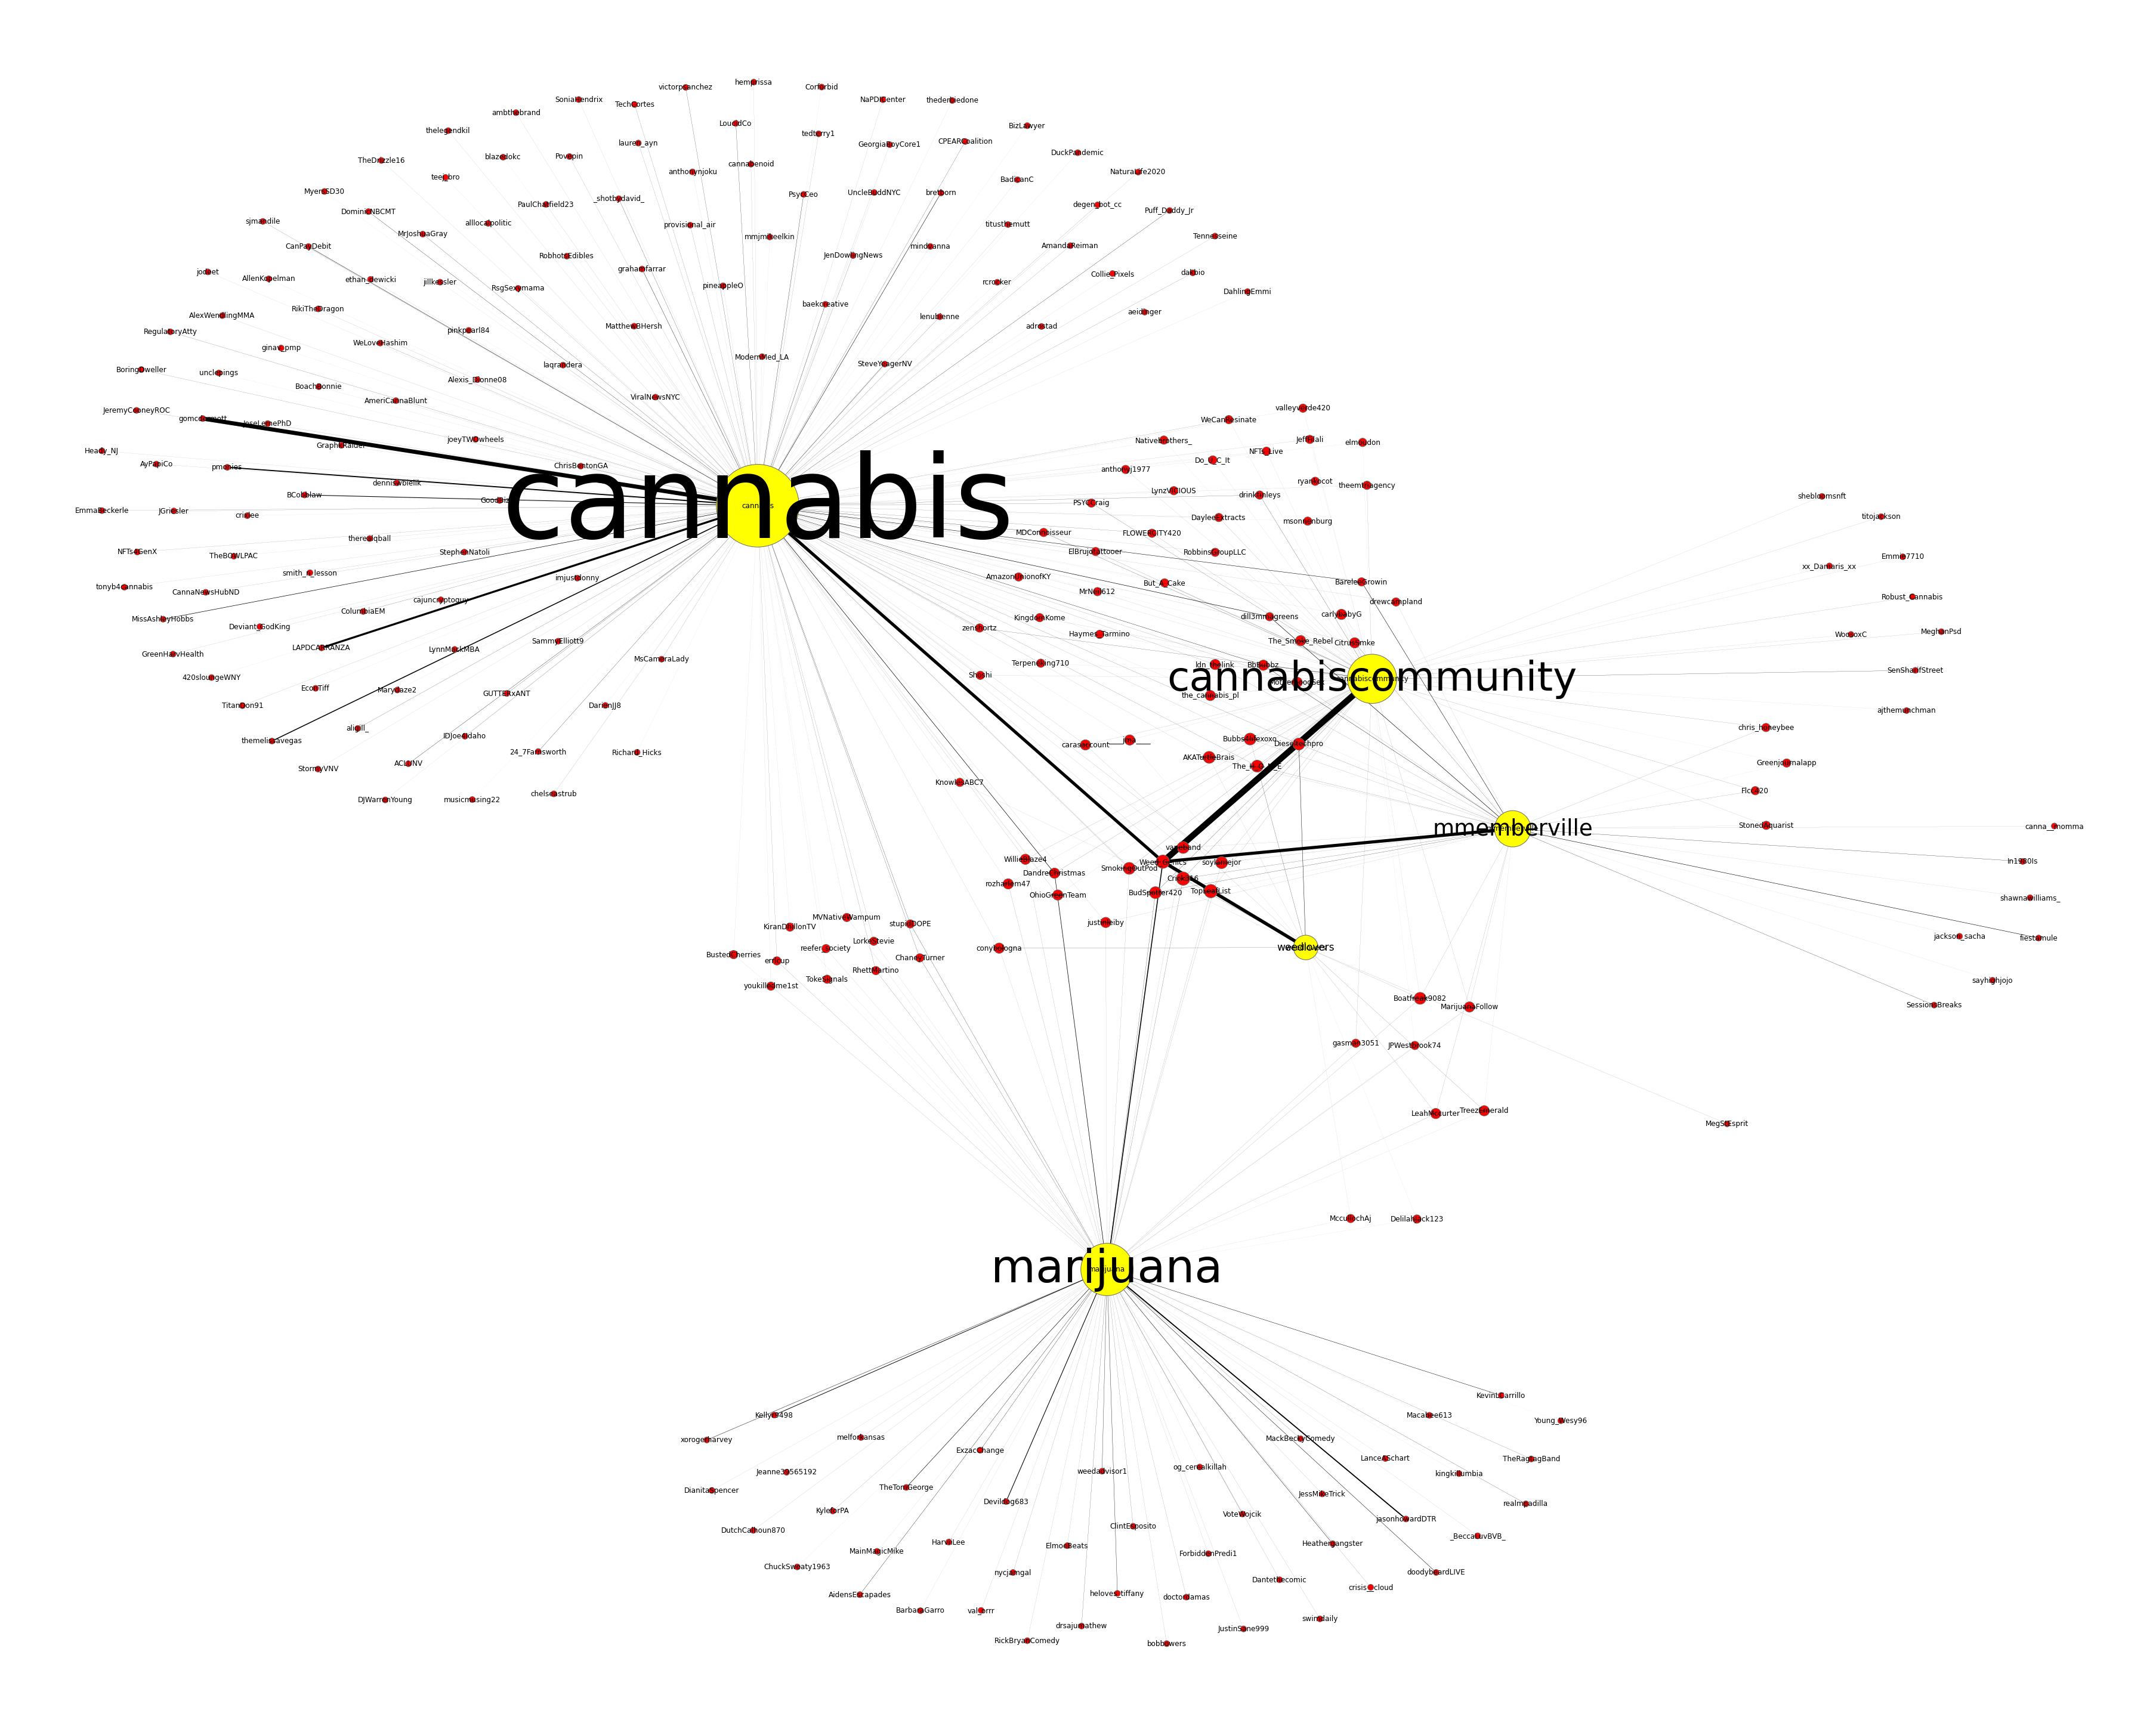

In [65]:
d= dict(G.degree)
pos = nx.spring_layout(G)
plt.figure(figsize=(50,40))
nx.draw(G, pos=pos,with_labels =True, node_color = colorsBefore,
        node_size = [ v * 100 for v in dict(G.degree()).values()]
       ,width =[v[2]['likes']/70 for v in edgeListBefore])
for node,(x,y) in pos.items():
    text(x,y,node,fontsize= d[node], ha='center', va='center')

ax = plt.gca()
ax.collections[0].set_edgecolor("#696969")
plt.savefig("fig2.jpg", dpi=100)


In [76]:
usernameHAshtagAndLikes = list(zip(afterDf['User'], afterDf['Hashtags'], afterDf['like Count']))

username = []
hashtag = []
likes=[]
for i,j,k in usernameHAshtagAndLikes:
    if j != 'no hashtags':
        
        for a in ast.literal_eval(j):
            username.append(i)
            hashtag.append(a)
            likes.append(k)
nodesAfter = zip(username,hashtag,likes) 

In [77]:
zippedAfter = list(zip(username, hashtag,likes))
nodesAfter = pd.DataFrame(zippedAfter, columns=['username', 'hashtag','likes'])

In [78]:
df3 = nodesAfter['hashtag'].value_counts().iloc[:10].rename_axis('val').reset_index(name='count')

In [79]:
topTenAfter = df3['val'].values.tolist()

In [80]:
topTenValuesAfter = []
for i,j,k in zippedAfter:
    
    if j in topTenAfter:
        
        topTenValuesAfter.append((i,j,k))
        
        

In [81]:
nodesTenAfter = pd.DataFrame(topTenValuesAfter, columns=['username', 'hashtag','likes'])

In [82]:
nodesTenAfter['hashtag'].unique()

array(['legalizeit', 'marijuana', 'cannabiscommunity', 'cannabis',
       'cannabisindustry', 'biden', 'cannabisnews', 'mmemberville',
       'stonerfam', 'bidenpardons'], dtype=object)

In [83]:
import networkx as nx

from  matplotlib.pyplot import figure, text
G = nx.Graph()
G = nx.from_pandas_edgelist(nodesTenAfter,'hashtag','username',edge_attr =True)
edgeListAfter = nx.to_edgelist(G)


In [84]:
colorsAfter =[]

for node in G:
    
    if node in nodesTenAfter['username'].values:
        colorsAfter.append("red")
    else:
        colorsAfter.append("yellow")

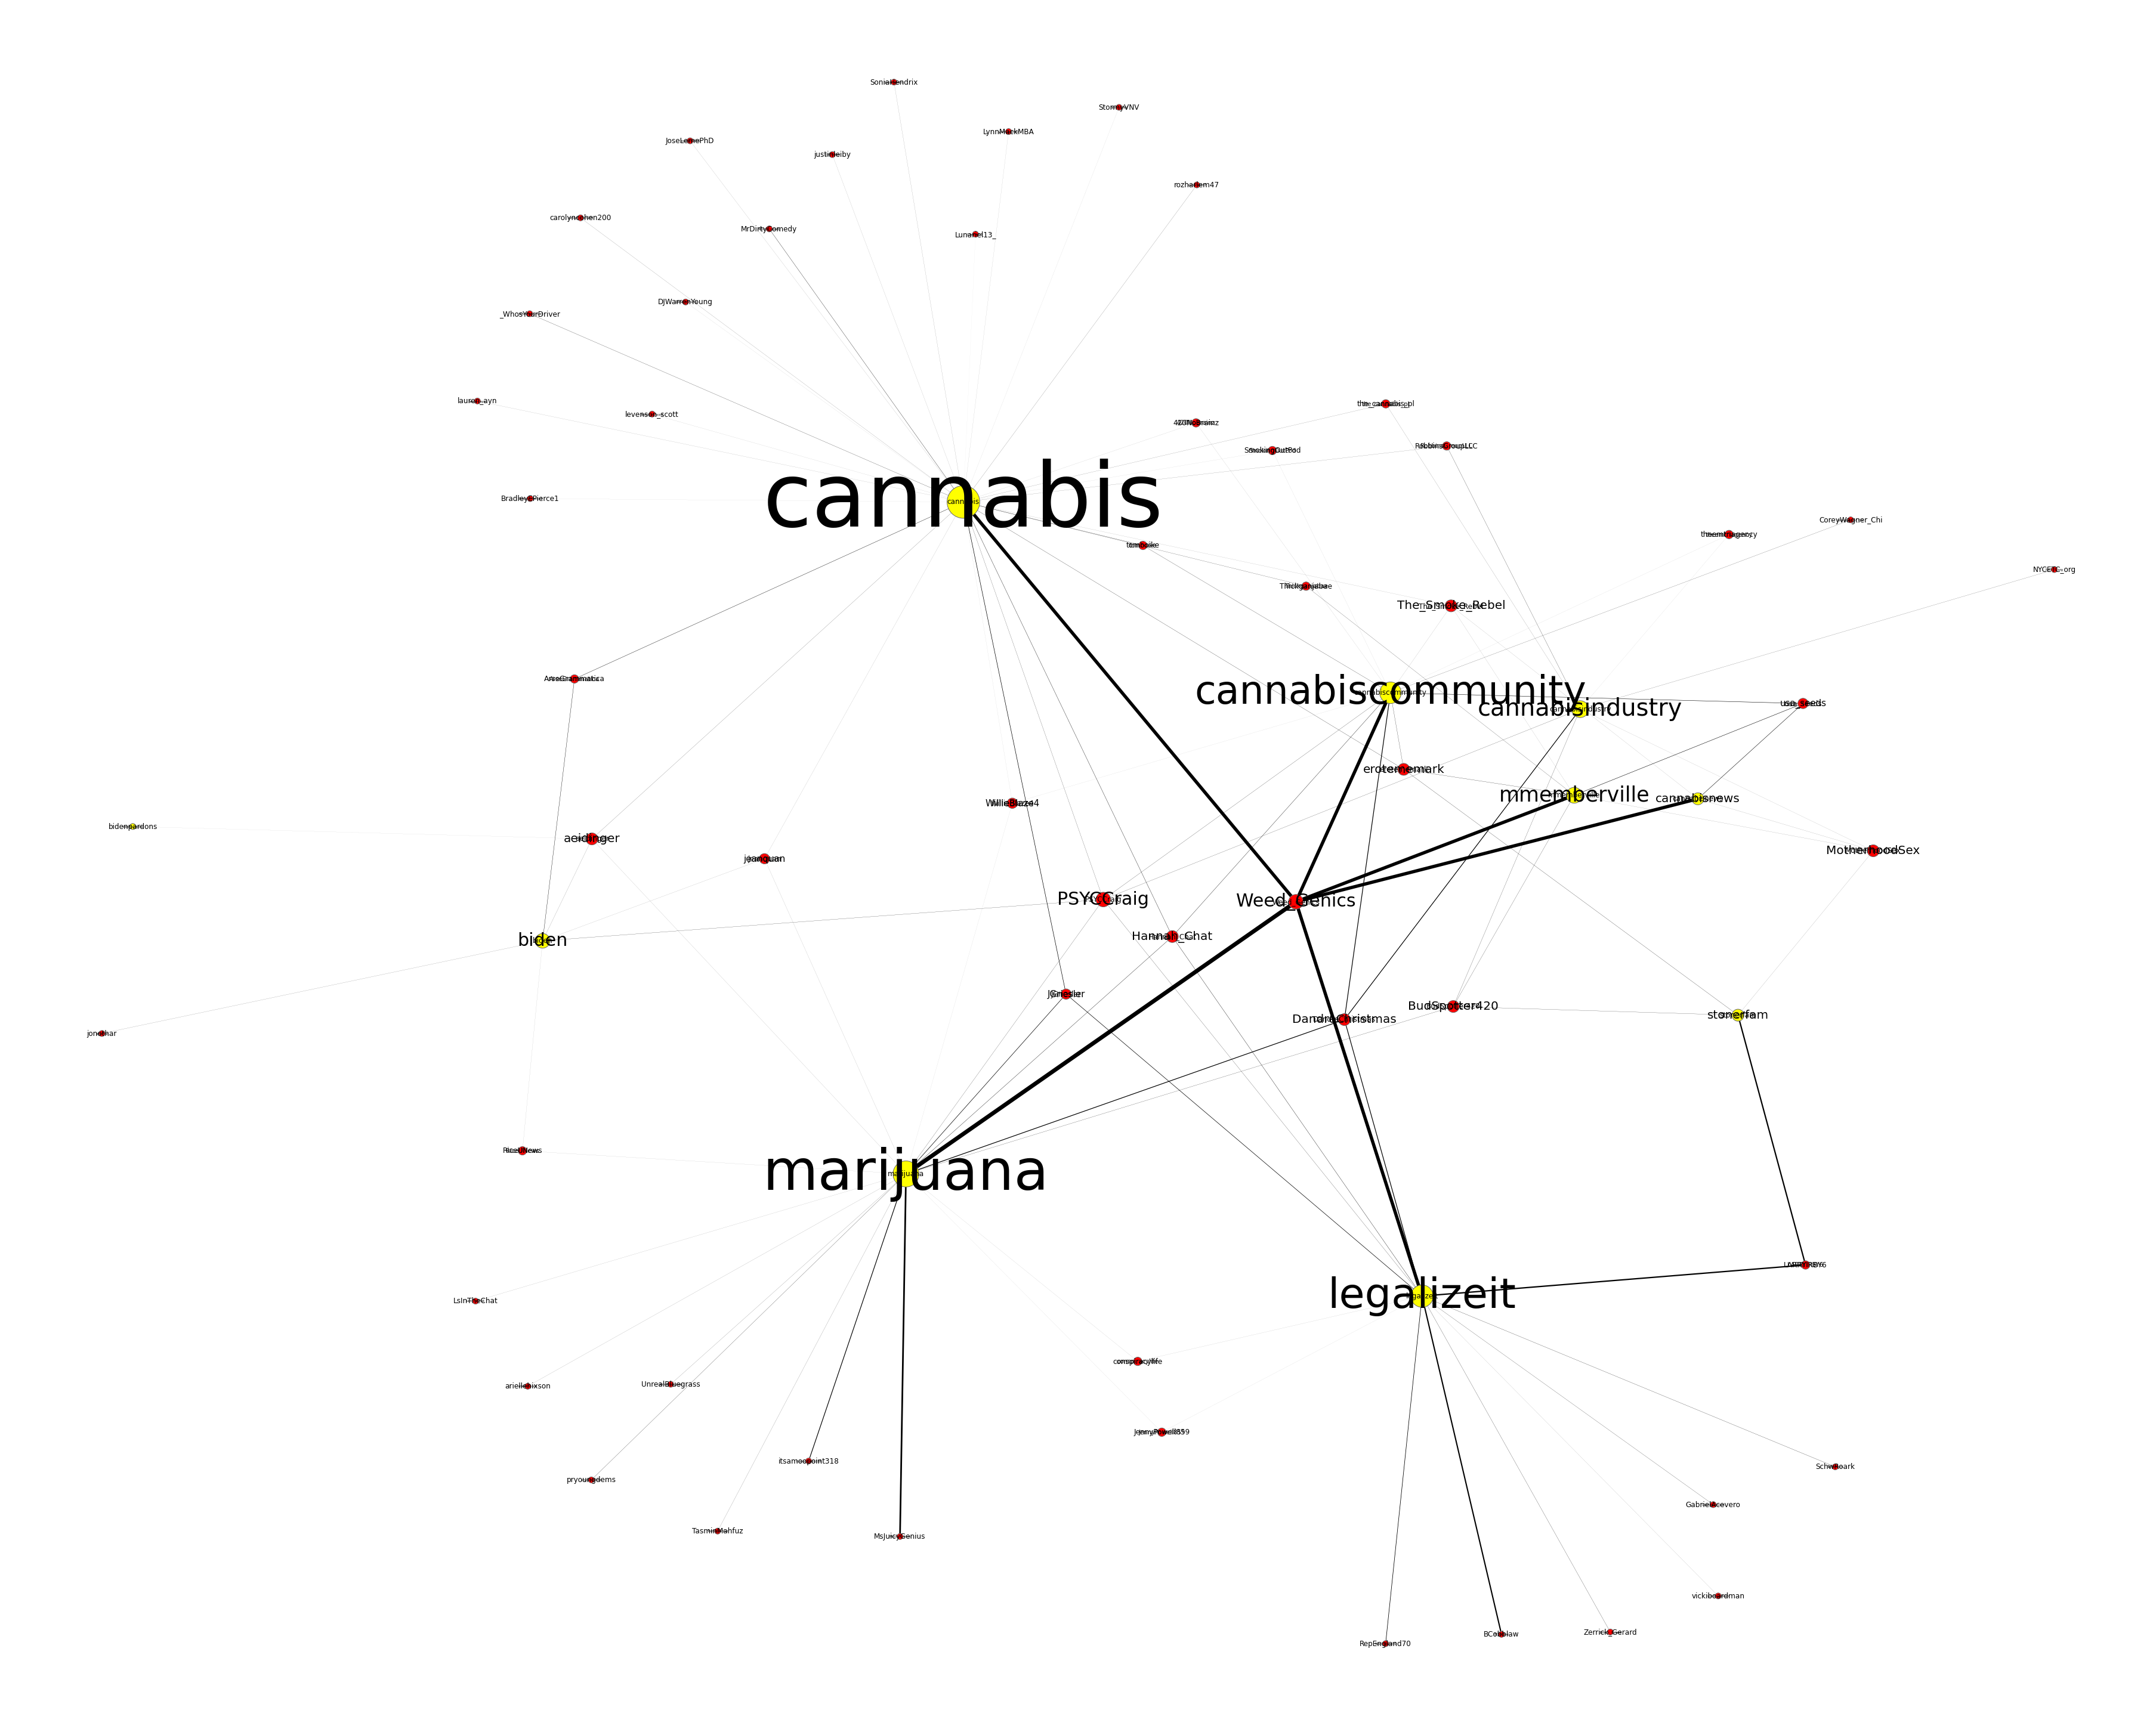

In [88]:
d= dict(G.degree)
pos = nx.spring_layout(G)
plt.figure(figsize=(50,40))
nx.draw(G, pos=pos,with_labels =True, node_color = colorsAfter,
        node_size = [ v * 100 for v in dict(G.degree()).values()]
       ,width =[v[2]['likes']/50 for v in edgeListAfter])
for node,(x,y) in pos.items():
    text(x,y,node,fontsize= d[node]*5, ha='center', va='center')

ax = plt.gca()
ax.collections[0].set_edgecolor("#696969")
plt.savefig("fig2.jpg", dpi=100)
